# Машинное обучение – весна 2024

# Домашнее задание 2: Логистическая регрессия, метод опорных векторов, работа с текстами

Правила:

- Домашнее задание оценивается в 10 баллов.

- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

- Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

- Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

# Задание 1: LR, SVM и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: пользуемся .predict_proba(), который выдает вероятности принадлежности к классам, решается задача мягкой классификации

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [4]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


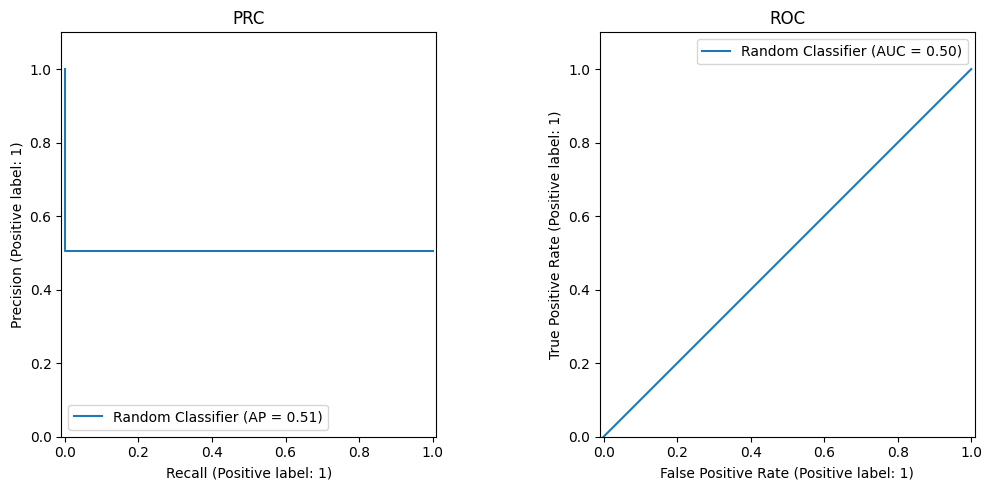

In [5]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()

 
depict_pr_roc(y_test, y_random, 'Random Classifier')

In [6]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [7]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [8]:
def AUC_PR_score(clf, X, y):
    y_pred = clf.predict(X)
    precision, recall, _ = precision_recall_curve(y, y_pred)
    return auc(recall, precision)

In [10]:
from sklearn.model_selection import RandomizedSearchCV
svm = SVC(kernel='linear')
parameters = {'C': np.arange(0.1, 10, 0.1)}

grid = RandomizedSearchCV(svm, parameters, cv=3, scoring=AUC_PR_score)
grid.fit(X_train, y_train)

print(grid.best_params_)

{'C': 8.9}


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

In [9]:
classifier = SVC(kernel='linear', C=8.9)
classifier.fit(X_train, y_train)
y_pred_svm = classifier.predict(X_test)

SVC Classifier with C = 8.9 metrics
AUC-PR: 0.83369
AUC-ROC: 0.77514


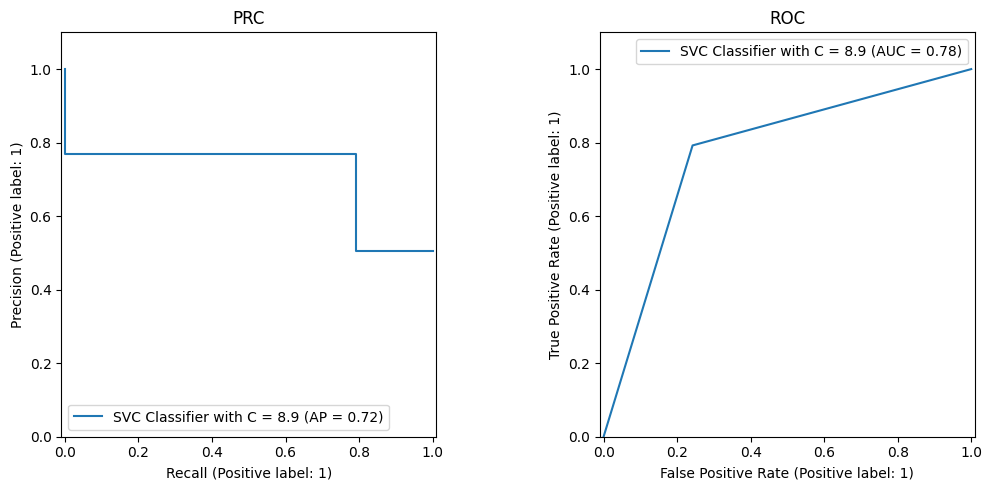

In [10]:
depict_pr_roc(y_test, y_pred_svm, 'SVC Classifier with C = 8.9')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [11]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_svm)
df_metrics.loc['SVC Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_pred_svm),
      8.9
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.0
SVC Classifier,0.833686,0.775138,8.9


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [12]:
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression()
parameters = {'C': np.arange(0.1, 10, 0.1)}

grid = GridSearchCV(lr, parameters, cv=5, scoring=AUC_PR_score)
grid.fit(X_train, y_train)

print(grid.best_params_)

{'C': 0.1}


LogisticRegression Classifier with C = 0.1 metrics
AUC-PR: 0.83278
AUC-ROC: 0.77363


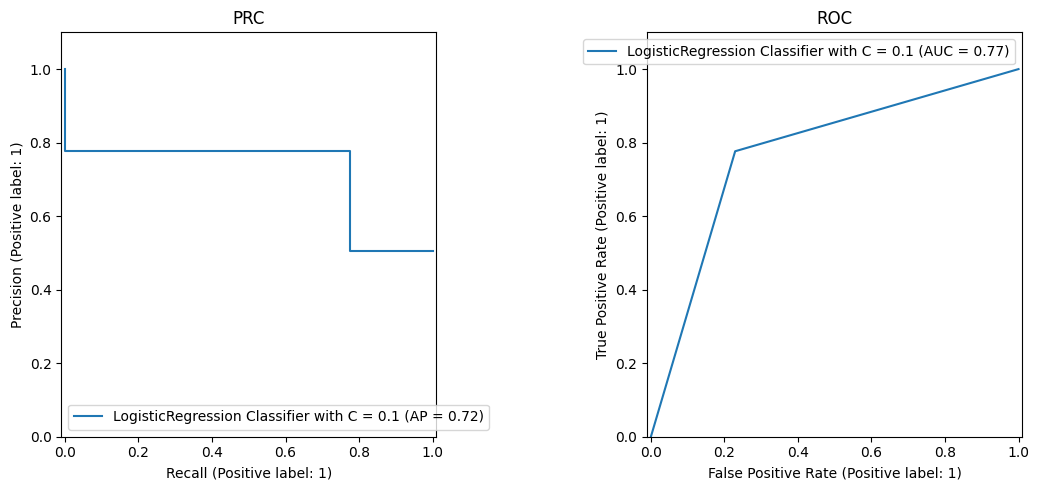

In [13]:
classifier = LogisticRegression(C = 0.1)
classifier.fit(X, y)
y_pred_lr = classifier.predict(X_test)
depict_pr_roc(y_test, y_pred_lr, 'LogisticRegression Classifier with C = 0.1')

In [14]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_lr)
df_metrics.loc['LogisticRegression Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_pred_lr),
      0.1
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.0
SVC Classifier,0.833686,0.775138,8.9
LogisticRegression Classifier,0.832777,0.773634,0.1


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

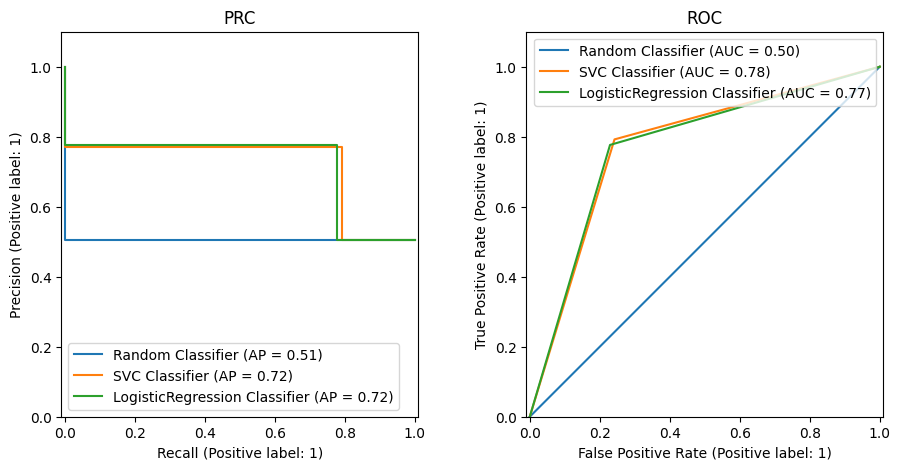

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
def depict(y_true, y_pred, classifier_name='Some Classifier', ax=ax):

  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)
  plt.legend()

depict(y_test, y_random, 'Random Classifier')
depict(y_test, y_pred_svm, 'SVC Classifier')
depict(y_test, y_pred_lr, 'LogisticRegression Classifier')

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000
SVC Classifier metrics
AUC-PR: 0.83369
AUC-ROC: 0.77514
LogisticRegression Classifier metrics
AUC-PR: 0.83278
AUC-ROC: 0.77363


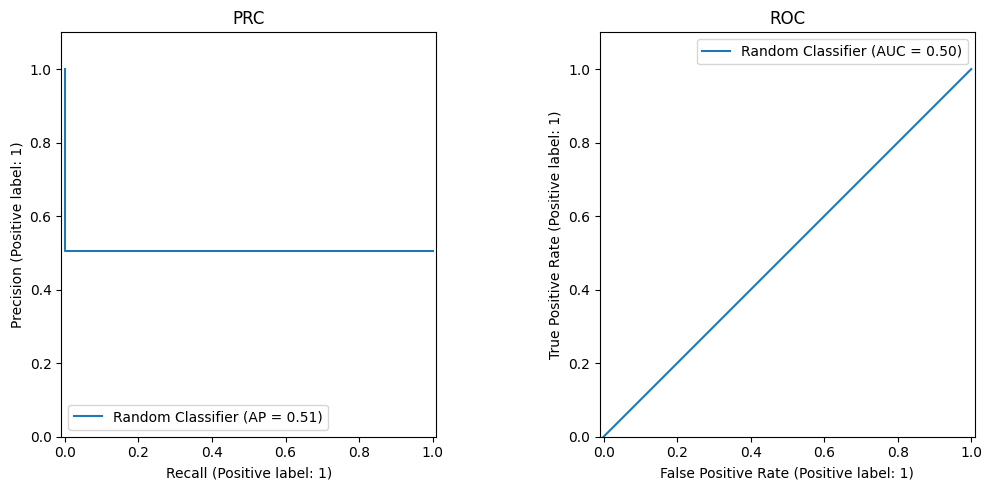

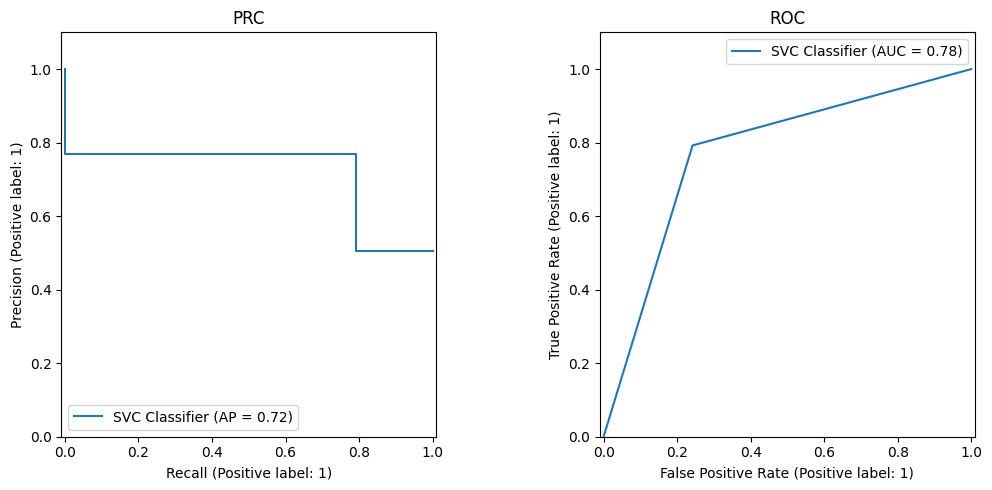

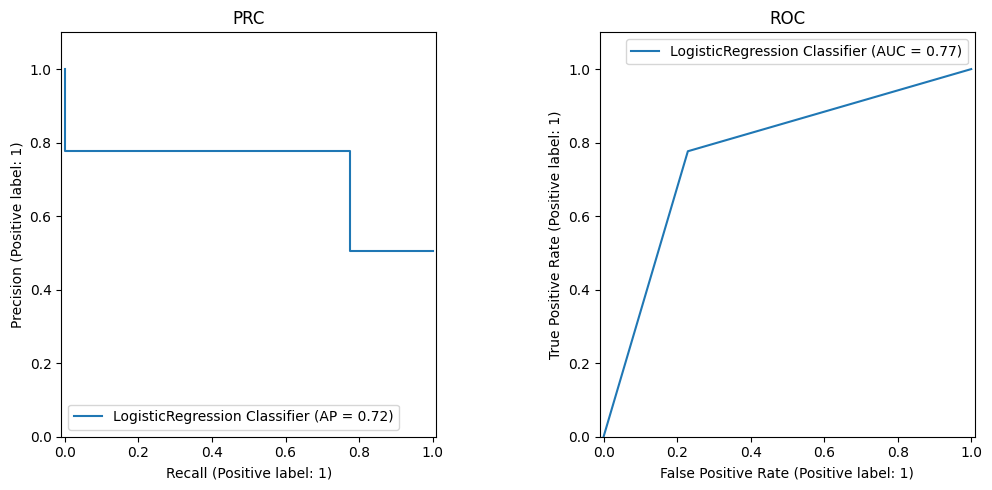

In [16]:
depict_pr_roc(y_test, y_random, 'Random Classifier')
depict_pr_roc(y_test, y_pred_svm, 'SVC Classifier')
depict_pr_roc(y_test, y_pred_lr, 'LogisticRegression Classifier')

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** обе модели лучше рандомной, по вычисленным метрикам разница незначительная

#### __Задание 1.2 Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [17]:
X, y = make_classification(
    n_samples=1000, n_features=2,  n_informative=2, n_redundant=0, random_state=42)

C:\Users\user\AppData\Local\Temp\ipykernel_2076\4279173538.py:14: UserWarning: The following kwargs were not used by contour: 'apha'
  plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], apha=0.5, linestyles=['--', '-', '--'])


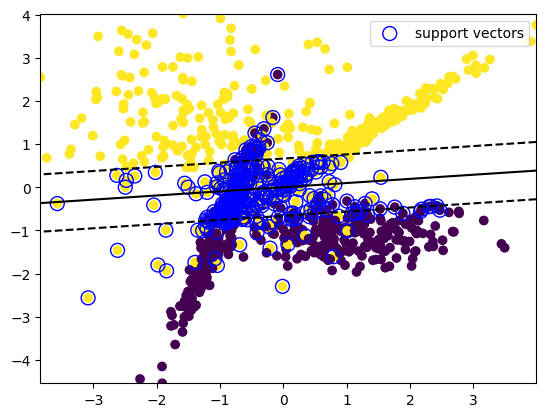

In [18]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    model.fit(X, y)
    model.predict(X)
    
    Z = model.coef_[0][0] * XX + model.coef_[0][1] * YY
    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], apha=0.5, linestyles=['--', '-', '--'])

    #Отрисовали выборку
    plt.scatter(X[:,0], X[:,1], c=y)

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(
                   model.support_vectors_[:,0], model.support_vectors_[:,1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')
    

    plt.legend()

plot_svm_2D(X, y, SVC(kernel='linear'))

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** те, на которых модель ошибается, и попадающие в разделяющую полосу

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

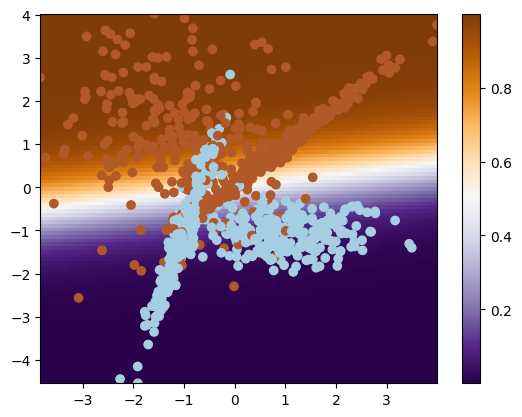

In [19]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    model.fit(X, y)
    model.predict(X)
    Z = 1/(1 + np.exp(-model.coef_[0][0] * XX - model.coef_[0][1] * YY))
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:,0], X[:,1], c=y,
                cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X, y, LogisticRegression())

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** как полоса, разделяющая классы; чем "глубже" в классе, то есть дальше от разделяющей полосы, тем больше уверенность в ответе - вероятность, близкая к 1, для положительного класса и к 0 – для отрицательного.

#### __Задание 1.3 Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [20]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l - r) / 2)
        bin_real_ratios.append(np.min(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

In [21]:
def plot_calibration_curve_corr(y_test, preds, model):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = (1.0 / n_bins) * i
        r = (1.0 / n_bins) * (i + 1)
        bin_middle_points.append((l + r) / 2)
        pred_bin = preds[(preds >= l) & (preds < r)]
        pred_bin_pos = y_test[(preds >= l) & (preds < r) & (y_test == 1)]
        bin_real_ratios.append(len(pred_bin_pos)/len(pred_bin))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios, label=f"Калибровка {model}")
    plt.plot([0, 1], [0, 1], "k:", label="Идеальная калибровка")
    plt.ylim([-0.05, 1.05])
    plt.legend()
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

**Внимание:** для получения вероятностей из метода опорных векторов требуется использовать формулу:

$$probas = \frac{preds - min(preds)}{max(preds) - min(preds)}$$

где $preds$ - результат работы метода decision_function

In [22]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
classifier1 = LogisticRegression()
classifier1.fit(X_train, y_train)
probas_lr = classifier1.predict_proba(X_test)[:, 1]

In [24]:
classifier2 = SVC(kernel='linear')
classifier2.fit(X_train, y_train)
preds = classifier2.decision_function(X_test)
probas_svm = (preds - np.min(preds))/(np.max(preds) - np.min(preds))

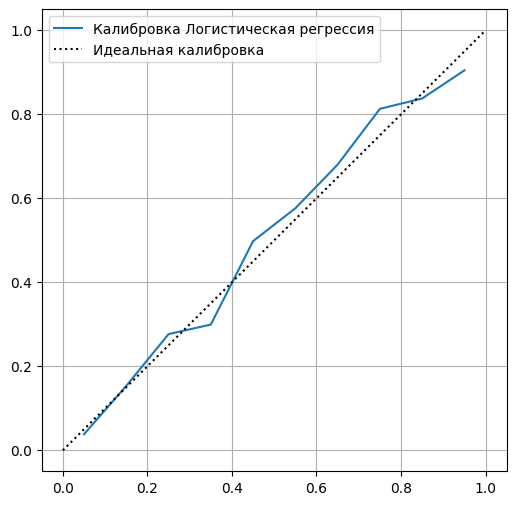

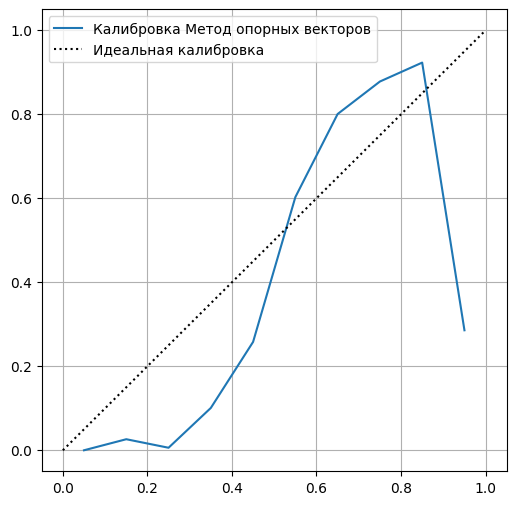

In [25]:
plot_calibration_curve_corr(y_test, probas_lr, "Логистическая регрессия")
plot_calibration_curve_corr(y_test, probas_svm, "Метод опорных векторов")

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** логистическая регрессия откалибрована хорошо, SVM – плохо, неуверенный классификатор

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

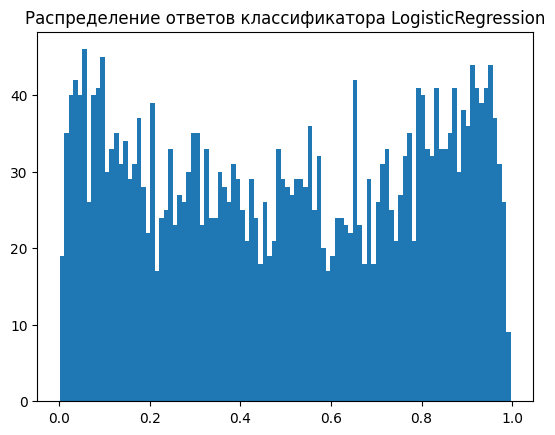

In [27]:
plt.hist(probas_lr, bins=100)
plt.title("Распределение ответов классификатора LogisticRegression")
plt.show()

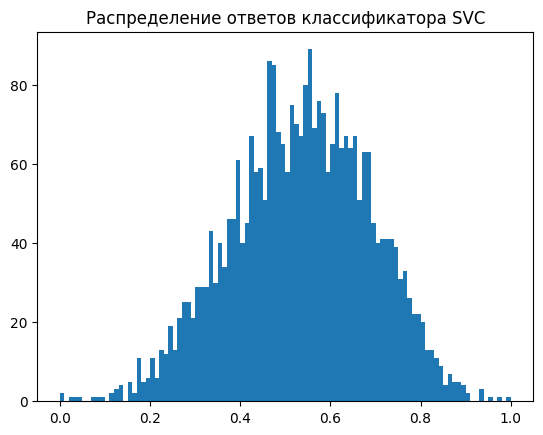

In [28]:
plt.hist(probas_svm, bins=100)
plt.title("Распределение ответов классификатора SVC")
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** вероятности, предсказанные методом SVM, тяготеют к 0.5 – неуверенный классификатор, может быть связано с тем, что SVM строится по граничным объектам, трудным для классификации; логистическая регрессия лучше предсказывает вероятности, так как обучается на log_loss, который также является метрикой качества калибровки

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

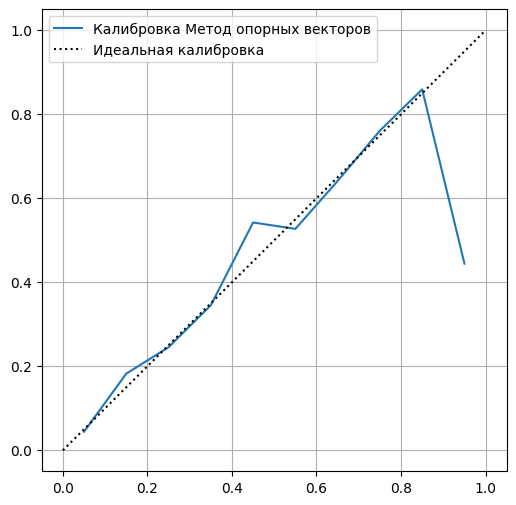

In [29]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_svm = CalibratedClassifierCV(estimator=classifier2, method="isotonic")
calibrated_svm.fit(X_train, y_train)
probas_svm_calibrated = calibrated_svm.predict_proba(X_test)[:, 1]
plot_calibration_curve_corr(y_test, probas_svm_calibrated, "Метод опорных векторов")

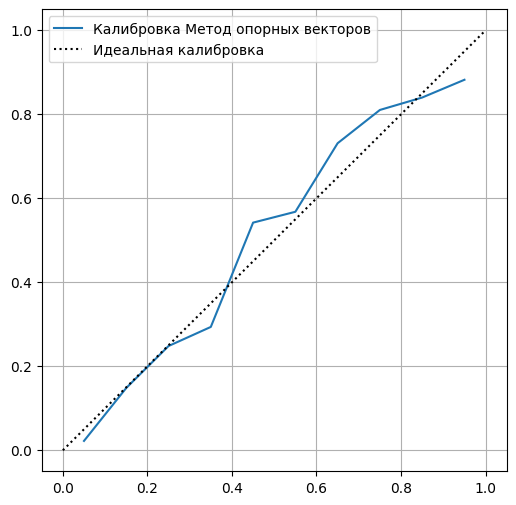

In [30]:
calibrated_svm = CalibratedClassifierCV(estimator=classifier2)
calibrated_svm.fit(X_train, y_train)
probas_svm_calibrated = calibrated_svm.predict_proba(X_test)[:, 1]
plot_calibration_curve_corr(y_test, probas_svm_calibrated, "Метод опорных векторов")

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** да, улучшилась

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

# Задание 2: Работа с текстами (8 баллов)

В этой части домашнего задания будем строить классификатор текстов!

Возьмем [данные из Kaggle соревнования](https://www.kaggle.com/competitions/nlp-getting-started/data)


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [31]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
from sklearn.metrics import f1_score

In [32]:
data = pd.read_csv('train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [33]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

#### __Задание 2.1  Пропуски__ (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5329 entries, 1186 to 7270
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5329 non-null   int64 
 1   keyword   5285 non-null   object
 2   location  3569 non-null   object
 3   text      5329 non-null   object
 4   target    5329 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 249.8+ KB


In [35]:
train = train.fillna("")

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5329 entries, 1186 to 7270
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5329 non-null   int64 
 1   keyword   5329 non-null   object
 2   location  5329 non-null   object
 3   text      5329 non-null   object
 4   target    5329 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 249.8+ KB


#### __Задание 2.2  Разведочный анализ данных__ (1 балл)

Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [37]:
train["target"].value_counts()

target
0    3024
1    2305
Name: count, dtype: int64

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [38]:
train[train["keyword"] != ""].value_counts(subset = "keyword")[0:15]

keyword
damage               36
siren                35
wreckage             34
fatalities           33
deluge               31
emergency            30
refugees             30
harm                 30
derail               30
twister              30
tsunami              30
fear                 30
nuclear%20reactor    30
fatality             30
bombed               29
Name: count, dtype: int64

In [39]:
popular_keywords = train[train["keyword"] != ""].value_counts(subset = "keyword")[0:14].index

In [40]:
popular_keywords_1 = np.hstack((popular_keywords, popular_keywords))

In [41]:
amount_0 = []
amount_1 = []
for word in popular_keywords:
    amount_0.append(train[(train["keyword"] == word) & (train["target"] == 0)].shape[0])
    amount_1.append(train[(train["keyword"] == word) & (train["target"] == 1)].shape[0])
    amount = np.hstack((amount_0, amount_1))
    target = np.hstack((np.zeros(len(popular_keywords), dtype=int), np.ones(len(popular_keywords), dtype=int)))
df = pd.DataFrame({'word':popular_keywords_1, 'amount':amount, 'target':target})

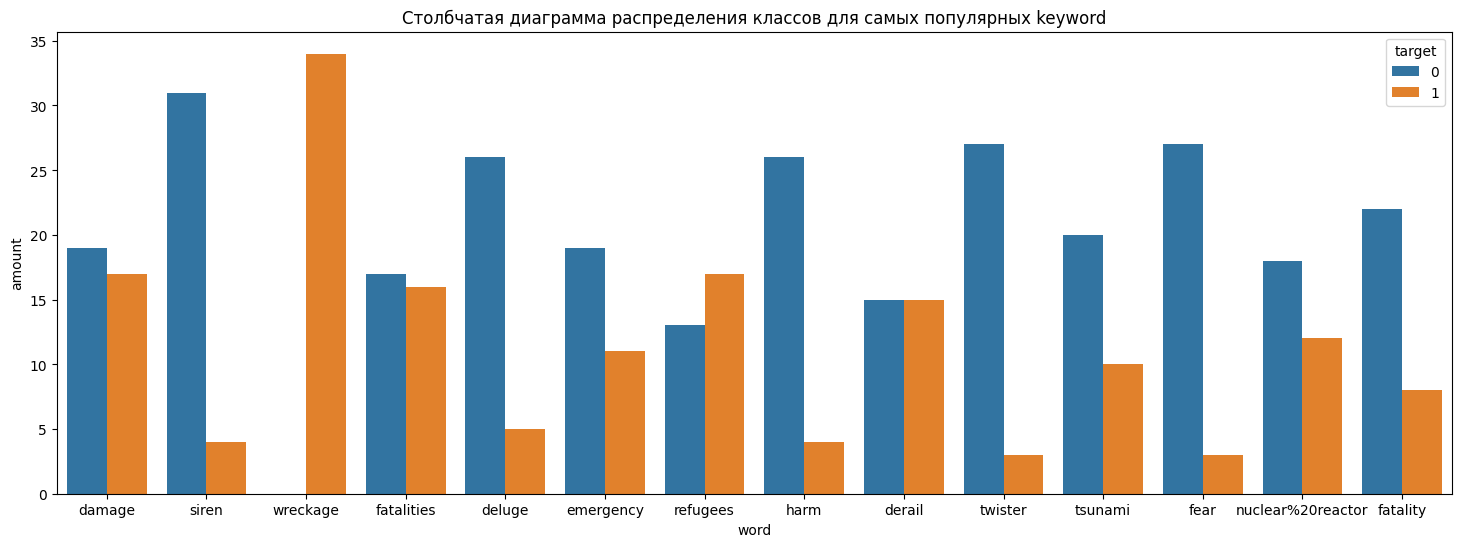

In [42]:
fig, ax = plt.subplots(figsize = (18,6)) 
sns.barplot(data=df, x = 'word', y = 'amount',hue ='target', ax = ax)
plt.title("Столбчатая диаграмма распределения классов для самых популярных keyword")
plt.show()

**Ответ:** для большинства слов твит не о катастрофе, но для слова wreckage получаем, что все твиты действительно о реальном бедствии

#### __Задание 2.3  Подготовка__ (1 балл)

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [43]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [44]:
df = train.drop('id', axis = 1)

In [45]:
df['text'] = df['keyword'].astype(str) + " "+ df['location'].astype(str) + " " + df['text'].astype(str)
train_new = df.drop(['keyword', 'location'], axis = 1)

In [46]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


Далее мы будем пока работать только с train частью. Предобработайте данные (train часть) с помощью CountVectorizer. Какого размера получилась матрица?

In [47]:
texts = train_new["text"]

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
cnt_vec = CountVectorizer()
X = cnt_vec.fit_transform(texts)

In [49]:
len(cnt_vec.vocabulary_.keys())

18455

In [50]:
pd.DataFrame(X.toarray(), columns=cnt_vec.vocabulary_.keys())

,bridge,20collapse,ashes,2015,australia,ûªs,collapse,at,trent,among,worst,in,history,england,bundled,out,for,60,http,co,t5trhjuau0,hail,carol,stream,illinois,great,michigan,technique,camp,b1g,thanks,to,bmurph1019,hail_youtsey,termn8r13,goblue,wrestleon,oaskgki6qj,police,houston,cnn,tennessee,movie,theater,shooting,suspect,killed,by,di8elzswnr,rioting,...,pedals,bowery,mesgcngaz0,onfireanders,_dmerida,nataly,cheer,poconorecord,emergencymgtmag,households,7zlsumiess,tdcch01n7q,yg32yb2jdy,chann,spa,ex6jzqj3ni,quoted,purported,swvuzxi6gt,xrp0rtkffj,volleyball,dcdecfv934,dwbc1duvdk,kesabaran,membuahkan,hasil,indah,pada,saat,tepat,connection,income,policies,buckley,babmf0w2yw,eganator2000,bills,omron,hem,712c,monitor,cuffs,gjbainqwn9,jphgpl1c5x,developing,symptoms,rqkk15uhey,stamford,shropshire,easlgea1b7
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5324,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5325,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5326,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5327,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Ответ:** 5329 rows × 18455 columns

#### __Задание 2.4  Работа со словарем__ (1 балл)


В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось?

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [51]:
cnt_vec.vocabulary_.keys()

dict_keys(['bridge', '20collapse', 'ashes', '2015', 'australia', 'ûªs', 'collapse', 'at', 'trent', 'among', 'worst', 'in', 'history', 'england', 'bundled', 'out', 'for', '60', 'http', 'co', 't5trhjuau0', 'hail', 'carol', 'stream', 'illinois', 'great', 'michigan', 'technique', 'camp', 'b1g', 'thanks', 'to', 'bmurph1019', 'hail_youtsey', 'termn8r13', 'goblue', 'wrestleon', 'oaskgki6qj', 'police', 'houston', 'cnn', 'tennessee', 'movie', 'theater', 'shooting', 'suspect', 'killed', 'by', 'di8elzswnr', 'rioting', 'still', 'couple', 'of', 'hours', 'left', 'until', 'have', 'be', 'up', 'class', 'wounds', 'lake', 'highlands', 'crack', 'the', 'path', 'where', 'wiped', 'this', 'morning', 'during', 'beach', 'run', 'surface', 'on', 'elbow', 'and', 'right', 'knee', 'yaqrsximph', 'airplane', '20accident', 'somewhere', 'there', 'experts', 'france', 'begin', 'examining', 'debris', 'found', 'reunion', 'island', 'french', 'air', 'accident', 'tagzbcxfj0', 'mlb', 'bloody', 'isolated', 'city', 'world', 'pert

In [52]:
import re

In [53]:
def contains_digit(s: str) -> bool:
    #Проверка, содержит ли слово цифры
    result = re.findall("\\d", s)
    return result != []
    
def contains_punctuation(s: str) -> bool:
    #Проверка, содержит ли слово пунктуацию
    result = re.findall("[^0-9a-zA-Z]", s)
    return result != []

def is_hashtag(s: str) -> bool:
    #Проверка, является ли слово хэштегом
    result = re.findall("^#.*", s)
    return result != []

def is_mention(s: str) -> bool:
    #Проверка, является ли слово упоминанием
    result = re.findall("^@.*", s)
    return result != []

def investigate_vocabulary(vocabulary):
    digit = 0
    punctuation = 0
    hashtag = 0
    mention = 0
    for word in vocabulary.keys():
        digit += int(contains_digit(word))
        punctuation += int(contains_punctuation(word))
        hashtag += int(is_hashtag(word))
        mention  += int(is_mention(word))
    
    print(f'With digit:       {digit}',
          )
    print(f'With punctuation: {punctuation}', 
          )
    print(f'Hashtags:         {hashtag}', 
          )
    print(f'Mentions:         {mention}', 
          )

In [54]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [55]:
investigate_vocabulary(cnt_vec.vocabulary_)

With digit:       3812
With punctuation: 433
Hashtags:         0
Mentions:         0


#### __Задание 2.5  Токенизация__ (0.5 балла)

По умолчанию CountVectorizer определяет токен (слово) как последовательность 2 и более цифр или букв. Пунктуационные символы воспринимаются как разделитель токенов. Такой подход может быть не очень полезен при анализе твитов.

Существуют токенайзеры - модели, которые разбивают тексты на токены (слова), они разные в зависимости от задачи (какие токены могут быть полезны в данной задаче?). Например, в nltk есть токенизатор для твитов - TweetTokenizer.

Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [56]:
import nltk

In [57]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer
tokenizer = TweetTokenizer()
twt_vec = CountVectorizer(tokenizer=tokenizer.tokenize)
X1 = twt_vec.fit_transform(texts)

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [58]:
pd.DataFrame(X1.toarray(), columns=twt_vec.vocabulary_.keys())

,bridge,%,20collapse,ashes,2015,:,australia,,ûªs,collapse,at,trent,among,worst,in,history,england,bundled,out,for,60,...,http://t.co/t5trhjuau0,hail,carol,stream,",",illinois,great,michigan,technique,camp,b1g,thanks,to,@bmurph1019,@hail_youtsey,.,@termn8r13,#goblue,#wrestleon,http://t.co/oaskgki6qj,police,houston,cnn,tennessee,movie,theater,shooting,suspect,...,bowery,http://t.co/mesgcngaz0,@onfireanders,@_dmerida,nataly,cheer,poconorecord,@emergencymgtmag,households,http://t.co/7zlsumiess,http://t.co/tdcch01n7q,http://t.co/yg32yb2jdy,chann,spa,http://t.co/ex6jzqj3ni,quoted,purported,http://t.co/swvuzxi6gt,http://t.co/xrp0rtkffj,#volleyball,volleyball,http://t.co/dcdecfv934,http://t.co/dwbc1duvdk,kesabaran,membuahkan,hasil,indah,pada,saat,tepat,connection,income,policies,buckley,http://t.co/babmf0w2yw,@eganator2000,bills,omron,hem,712c,monitor,cuffs,http://t.co/gjbainqwn9,http://t.co/jphgpl1c5x,developing,symptoms,http://t.co/rqkk15uhey,stamford,shropshire,http://t.co/easlgea1b7
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5324,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5325,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5326,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5327,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
investigate_vocabulary(twt_vec.vocabulary_)

With digit:       3939
With punctuation: 7466
Hashtags:         1470
Mentions:         1679


**Сравнение:** с этим токенайзером находим хэштеги и упоминания

#### __Задание 2.6  Кастомный токенайзер__ (2 балла)


В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно:

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer


In [60]:
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [61]:
def contains_only_latin_letters(s: str) -> bool:
    #Проверка, содержит ли слово только латинские буквы
    return bool(re.fullmatch("^[a-zA-Z]+$", s))

def is_emoji(s: str) -> bool:
    #Проверка, является ли слово смайликом
    return bool(bool(re.fullmatch("^[^0-9a-zA-Z]+$", s)) *
           bool(bool(re.fullmatch(r".*\).*", s)) + bool(re.fullmatch(r".*\(.*", s))))

def is_hashtag(s: str) -> bool:
    #Проверка, является ли слово хэштегом
    return bool(re.fullmatch("^#[a-zA-Z]*+$", s))
   

def custom_tokenizer(s: str) -> List[str]:
    #Кастомный токенайзер
    s = s.lower()
    tw = TweetTokenizer() 
    tokens1 = tw.tokenize(s)
    tokens2 = [s for s in tokens1 if (contains_only_latin_letters(s) == True or is_emoji(s) == True or is_hashtag(s) == True)]
    tokens3 = [s for s in tokens2 if (s not in stopwords.words('english'))]
    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(w) for w in tokens3]
    return tokens

In [62]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [63]:
for i in texts[0:10]:
    print(custom_tokenizer(i))

['bridg', 'ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']
['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class']
['wound', 'lake', 'highland', 'crack', 'path', 'wipe', 'morn', 'beach', 'run', 'surfac', 'wound', 'left', 'elbow', 'right', 'knee']
['airplan', 'somewher', 'expert', 'franc', 'begin', 'examin', 'airplan', 'debri', 'found', 'reunion', 'island', 'french', 'air', 'accid', 'expert', '#mlb']
['bloodi', 'isol', 'citi', 'world', 'perth', 'came', 'kill', 'indian', 'fun', 'video', 'smirk', 'remorseless', 'pakistani', 'killer', 'show', 'boast']
['burn', 'except', 'idk', 'realli', 'burn']
['destroy', '(', 'ask', ')', 'destroy', 'hous']
['wound', 'maracay', 'nirgua', 'venezuela', 'polic', 'offic', 'wound', 'suspect

#### __Задание 2.7  Обучаем модель__ (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.

2. Обучите LogisticRegression на полученных признаках.

3. Посчитайте метрику f1-score на тестовых данных.

In [64]:
df_test = test.drop('id', axis = 1)
df_test['text'] = df_test['keyword'].astype(str) + " "+ df_test['location'].astype(str) + " " + df_test['text'].astype(str)
test_new = df_test.drop(['keyword', 'location'], axis = 1)
texts_test = test_new["text"]
texts_test

2644    destruction nan So you have a new weapon that ...
2227    deluge nan The f$&amp;@ing things I do for #GI...
5448    police UK DT @georgegalloway: RT @Galloway4May...
132     aftershock nan Aftershock back to school kick ...
6845    trauma Montgomery County, MD in response to tr...
                              ...                        
4307    hellfire 570 Vanderbilt; Brooklyn, NY New cock...
3375    evacuation USA Bend Post Office roofers cut ga...
1710    collided nan Monsoon flooding - Monsoon rains ...
4898    massacre Ireland Remember this was a massacre ...
6753    tornado Asheville, NC I liked a @YouTube video...
Name: text, Length: 2284, dtype: object

In [65]:
cnt_vec = CountVectorizer(tokenizer=custom_tokenizer)
tok_train = cnt_vec.fit_transform(texts)
tok_test = cnt_vec.transform(texts_test)

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [66]:
clf = LogisticRegression()
clf.fit(tok_train, train["target"])
pred = clf.predict(tok_test)

In [67]:
print(f"F1: {f1_score(test["target"], pred):.3f}")

F1: 0.754


#### __Задание 2.8  Другой векторайзер и df__ (1 балл)

Повторите задание 2.7, но с tf-idf векторайзером. Как изменилось качество?

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)
tok_train1 = tfidf_vec.fit_transform(texts)
tok_test1 = tfidf_vec.transform(texts_test)

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [69]:
clf1 = LogisticRegression()
clf1.fit(tok_train1, train["target"])
pred1 = clf1.predict(tok_test1)

In [70]:
print(f"F1: {f1_score(test["target"], pred1):.3f}")

F1: 0.743


**Ответ:** качество понизилось

В векторайзерах есть параметры min_df и max_df - которые отвечают за ограничния минимальной и максимальной частоте встречаемости токена. Например, если min_df = 3, то мы не учитываем токены, которые встретились менее 3 раз в наших текстах.

Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?

In [71]:
tfidf_vec_max = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)
tok_train_max = tfidf_vec_max.fit_transform(texts)
tok_test_max= tfidf_vec_max.transform(texts_test)

clf2 = LogisticRegression()
clf2.fit(tok_train_max, train["target"])
pred_max = clf2.predict(tok_test_max)

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [72]:
print(f"F1: {f1_score(test["target"], pred_max):.3f}")

F1: 0.743


In [73]:
x = pd.DataFrame(tok_train1.toarray())

5329 rows × 10482 columns

In [74]:
x = pd.DataFrame(tok_train_max.toarray())

5329 rows × 10482 columns

**Ответ:** размер матрицы и, соответственно, качество не изменились -- нет токенов, которые встречались бы так часто.

In [75]:
tfidf_vec_max = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.052)
tok_train_max = tfidf_vec_max.fit_transform(texts)
tok_test_max= tfidf_vec_max.transform(texts_test)

clf2 = LogisticRegression()
clf2.fit(tok_train_max, train["target"])
pred_max = clf2.predict(tok_test_max)
print(f"F1: {f1_score(test["target"], pred_max):.3f}")

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1: 0.744


Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества?

In [76]:
tfidf_vec_min = TfidfVectorizer(tokenizer=custom_tokenizer, min_df=0.0003)
tok_train_min = tfidf_vec_min.fit_transform(texts)
tok_test_min= tfidf_vec_min.transform(texts_test)

clf3 = LogisticRegression()
clf3.fit(tok_train_min, train["target"])
pred_min = clf3.predict(tok_test_min)
print(f"F1: {f1_score(test["target"], pred_min):.3f}")

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1: 0.745


5329 rows × 4523 columns

**Ответ:** уменьшили число признаков более чем в 2 раза, качество выросло на 2 сотых